In [1]:
import sys
sys.path.append('../modules')

import utils
from RateEchoStateNet import RateEchoStateNet as RateNet

import numpy as np
from numba import njit, prange
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate

# Generate data from Lorenz attractor

In [4]:
xyz0 = np.random.rand(3)
sigma = 10
rho = 28
beta = 8/3

start = 0
end = 300
Time = np.linspace(start, end, int(2e5))

solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = xyz0, args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True)
solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = solver.sol(end), args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True, method = 'DOP853')
xyz = solver.sol(Time).T

xyz -= xyz.min(axis = 0)
xyz /= xyz.max(axis = 0)

xyz = np.ascontiguousarray(xyz[::2])
Time = Time[::2]

print(xyz.shape)

(100000, 3)


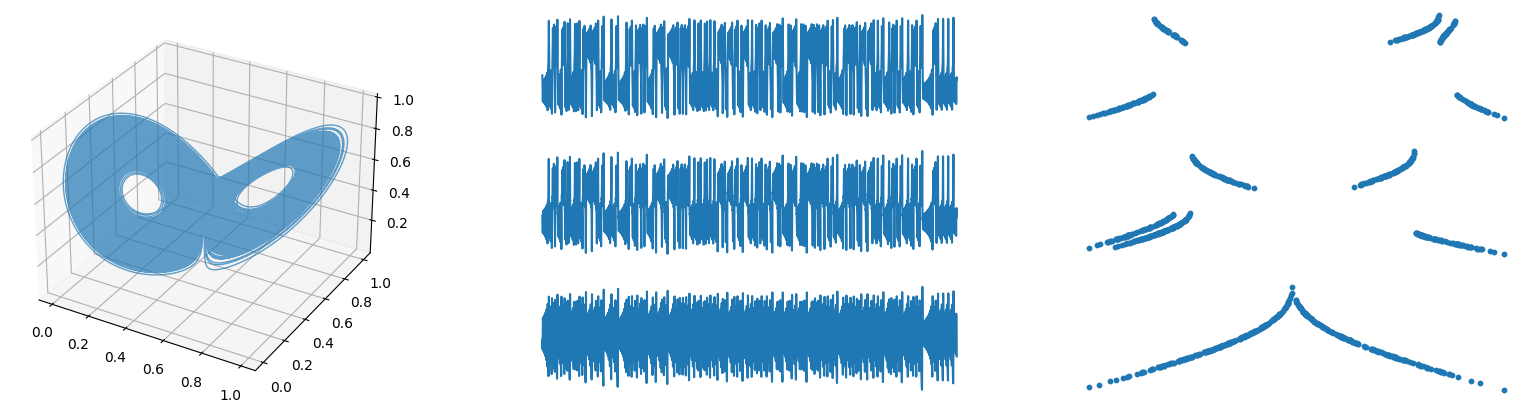

In [5]:
fig = plt.figure(figsize = (20,5))
axs = fig.subplot_mosaic('A03;A14;A25')
ss = axs['A'].get_subplotspec()
axs['A'].remove()
axs['A'] = fig.add_subplot(ss, projection='3d')
axs['A'].plot(*xyz.T, alpha=0.7, linewidth=1)

for i in range(3):
    axs[str(i)].plot(Time, xyz[:,i])
    axs[str(i)].axis('off')
    axs[str(i + 3)].scatter(*utils.return_map(xyz[:,i]), s = 10)
    axs[str(i + 3)].axis('off')
plt.show()

# Echo State Network

In [7]:
def run_nonlinearity(net, initTraining, idx_start, idx_echo, nLoops,
                     alpha_min = 1e-8, alpha_max = 1e-1, NAlpha = 30):
    net.fit_alpha(xyz, initTraining, idx_start, idx_echo, nLoops,
                  alpha_min = alpha_min, alpha_max = alpha_max, NAlpha = NAlpha)
    print("Best alpha: ", net.alpha)
    print("Best MSE: ", net.MSE_echo)

    E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start,
                                                 idx_echo = idx_echo, plot = True)
    
    net.plot_attractor(output_echo[idx_echo:])

    _ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)

    return net

In [6]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NInputs = 3

input_sparse = 0.3

dt = 0.05

tau_E = 1.
tau_I = 1.

np.random.seed(42)

Win = np.random.randn(NInputs, NE)
Win[Win < input_sparse] = 0

WEE = np.random.rand(NE, NE)
WEE[np.diag_indices(NE)] = 0

WII = np.random.rand(NI, NI)
WII[np.diag_indices(NI)] = 0

WIE = np.random.rand(NI, NE)
WEI = np.random.rand(NE, NI)

for W in [WIE, WII]:
            W /= np.sum(W, axis = 1)[..., None]
            
for W in [WEI, WEE]:
    W /= (np.sum(W, axis = 1) + Win.sum(axis = 0))[..., None]

In [9]:
initTraining = 100
idx_start = 5000
idx_echo = 1000
nLoops = 10000

## ReLU activation function

In [10]:
net_ReLU = RateNet(NE, NI, NInputs, dt, tau_E, tau_I, burnSteps = None,
                   input_sparse = input_sparse, max_bias = 2,
                   method = 'rk4', nonlinearity = utils.ReLU, args_nonlin = ())

net_ReLU._set_network(WEE, WII, WEI, WIE, Win)

New MSE: 37.44408 for alpha = 1e-08
New MSE: 14.42926 for alpha = 0.01034483655172414
New MSE: 14.34435 for alpha = 0.013793112068965519
Best alpha:  0.013793112068965519
Best MSE:  14.344346760372924


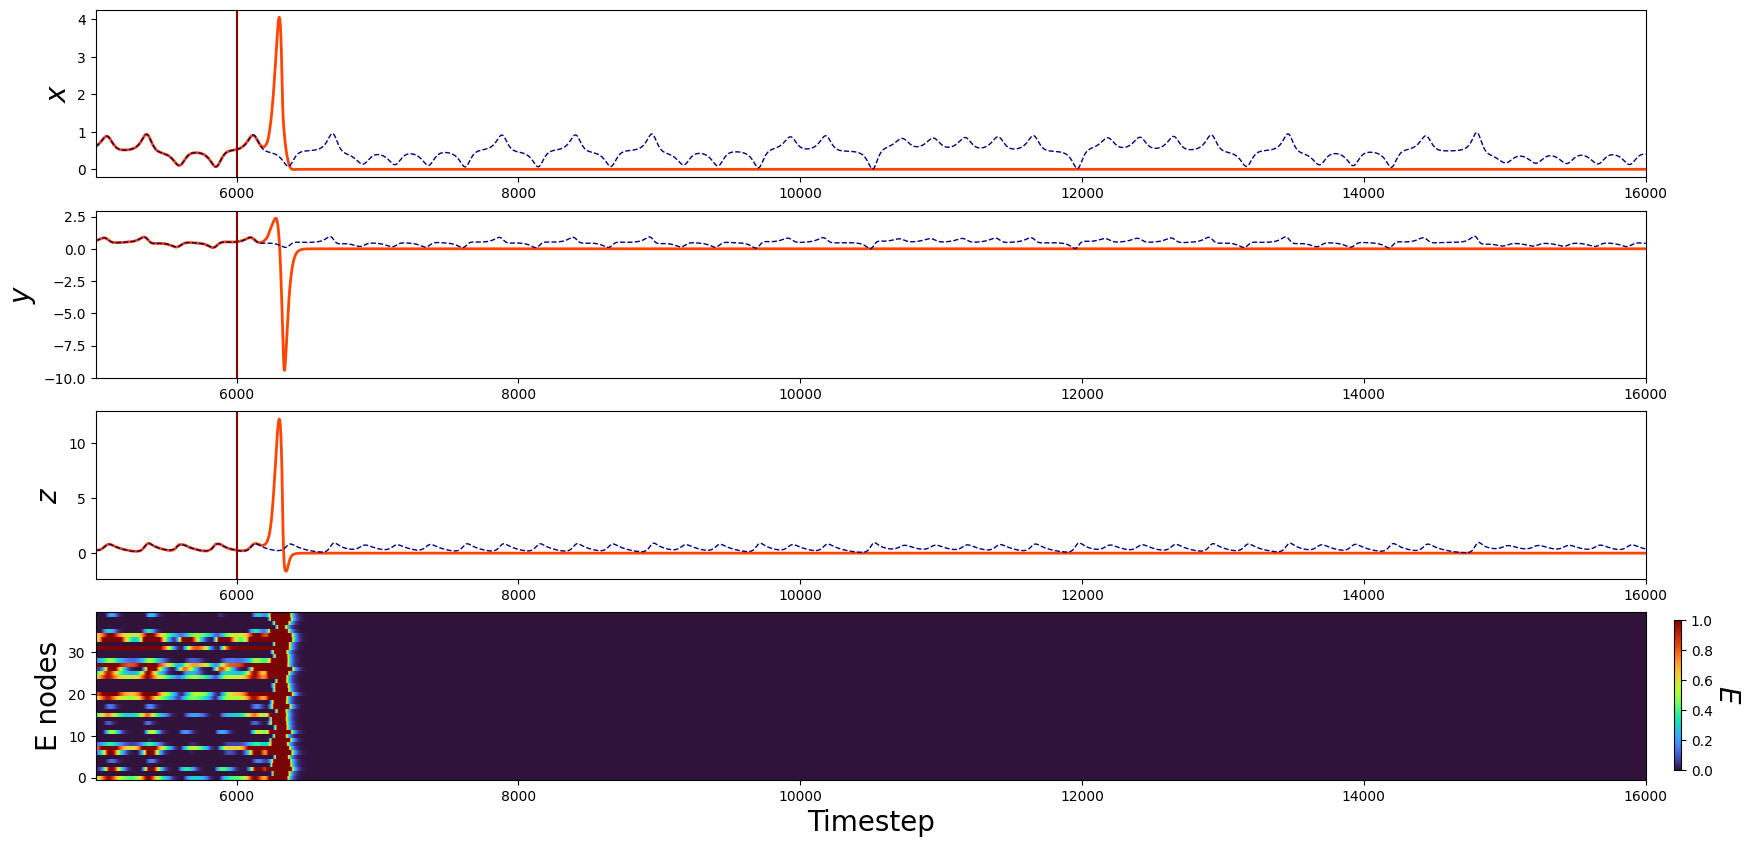

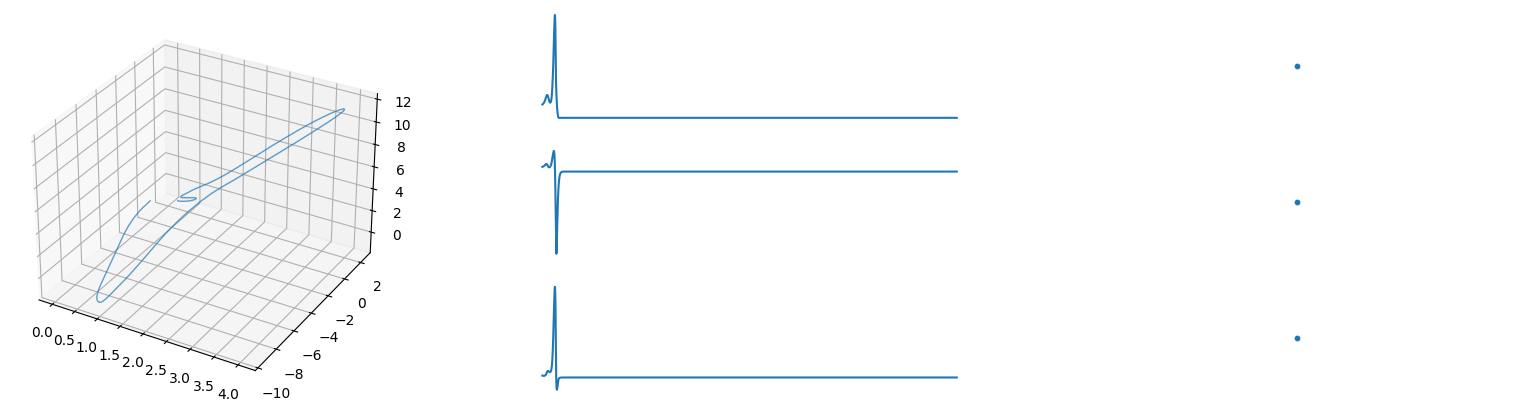

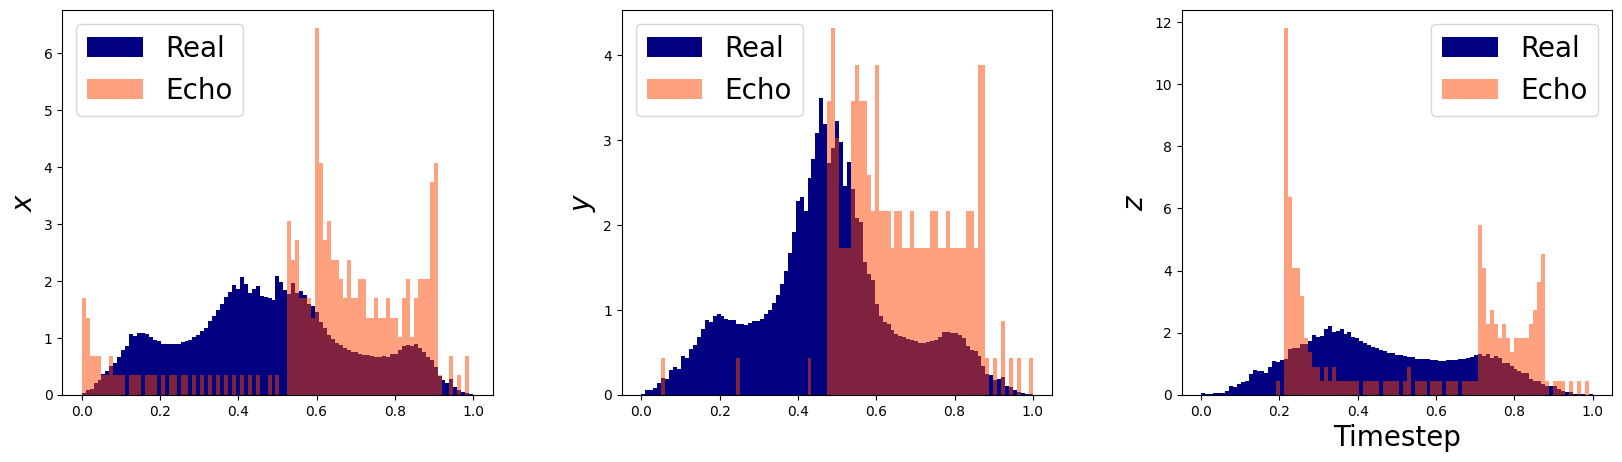

In [12]:
net_ReLU = run_nonlinearity(net_ReLU, initTraining, idx_start, idx_echo, nLoops)

## Sigmoid activation function

In [13]:
net_sigm = RateNet(NE, NI, NInputs, dt, tau_E, tau_I, burnSteps = None,
                   input_sparse = input_sparse, max_bias = None,
                   method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

net_sigm._set_network(WEE, WII, WEI, WIE, Win)

New MSE: 1.73815 for alpha = 1e-08
Best alpha:  1e-08
Best MSE:  1.738151885053565


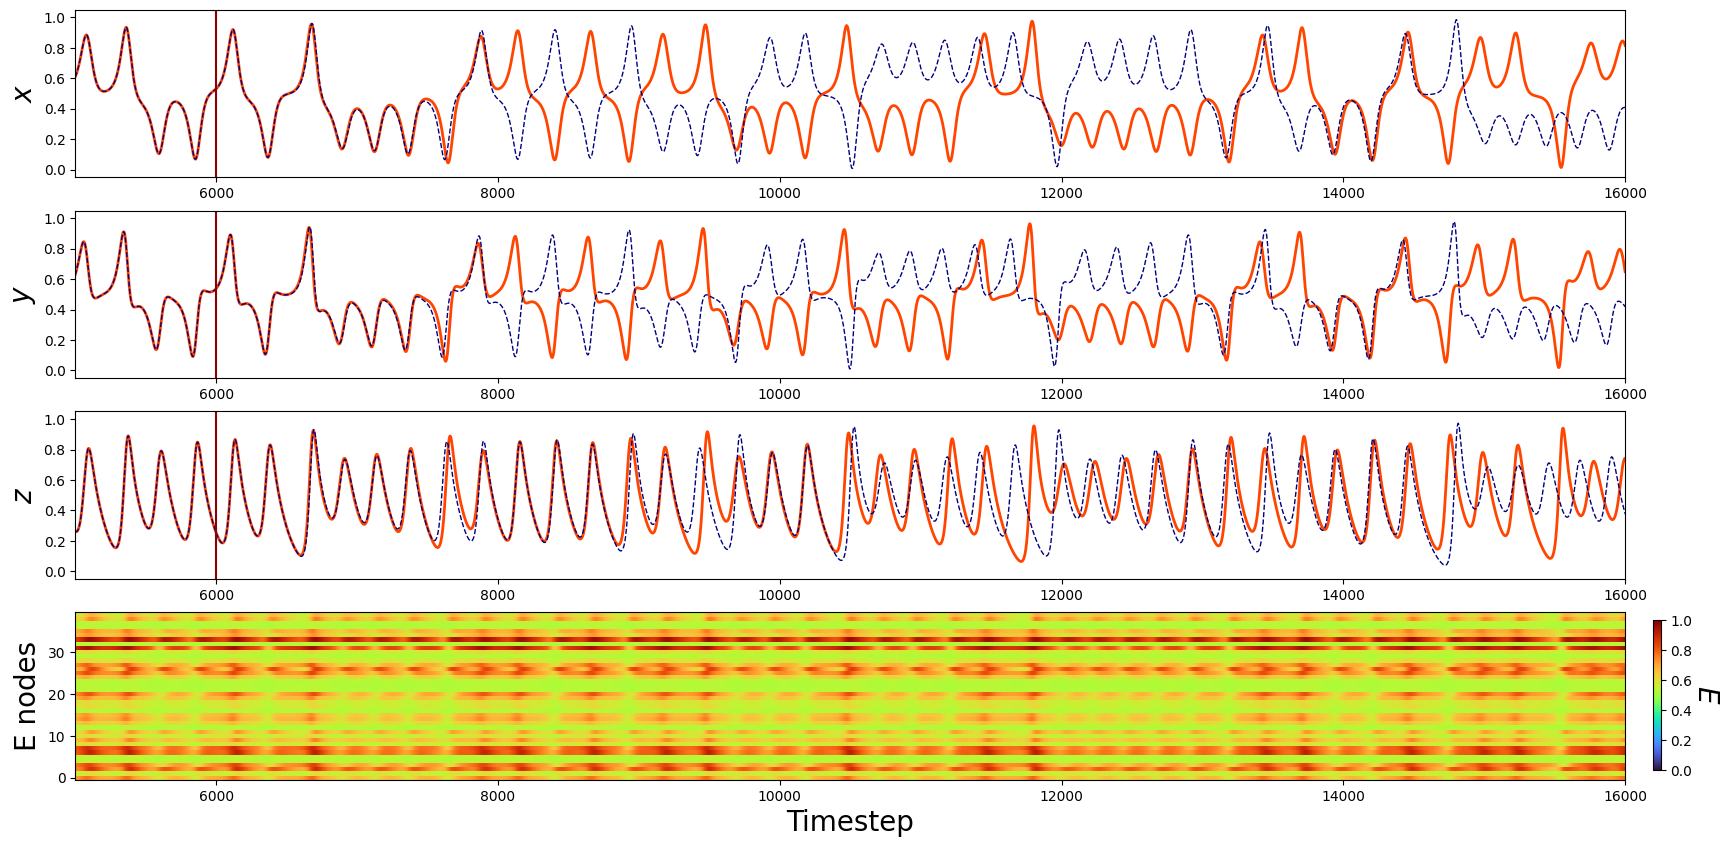

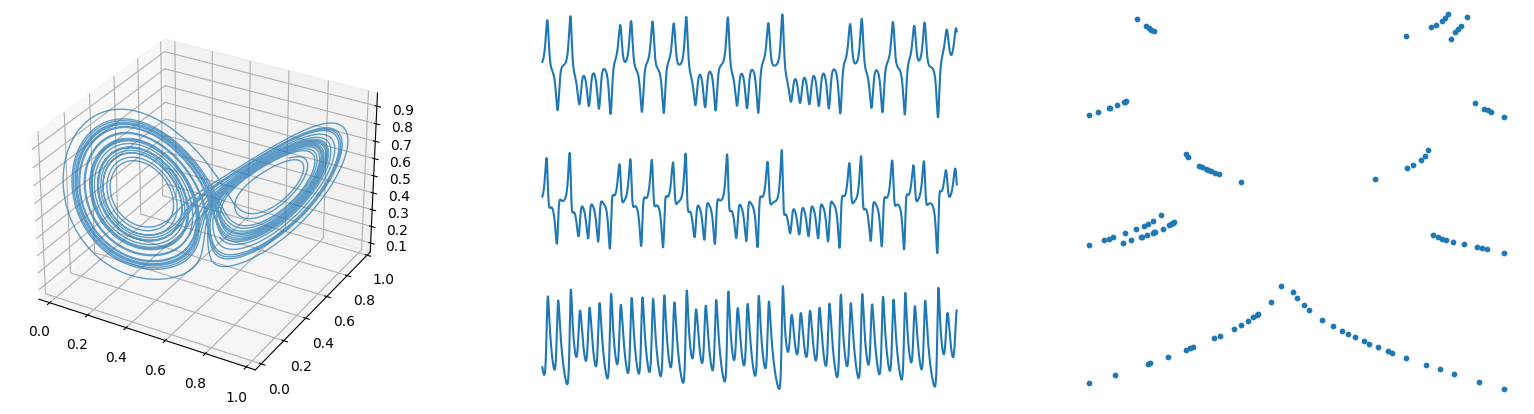

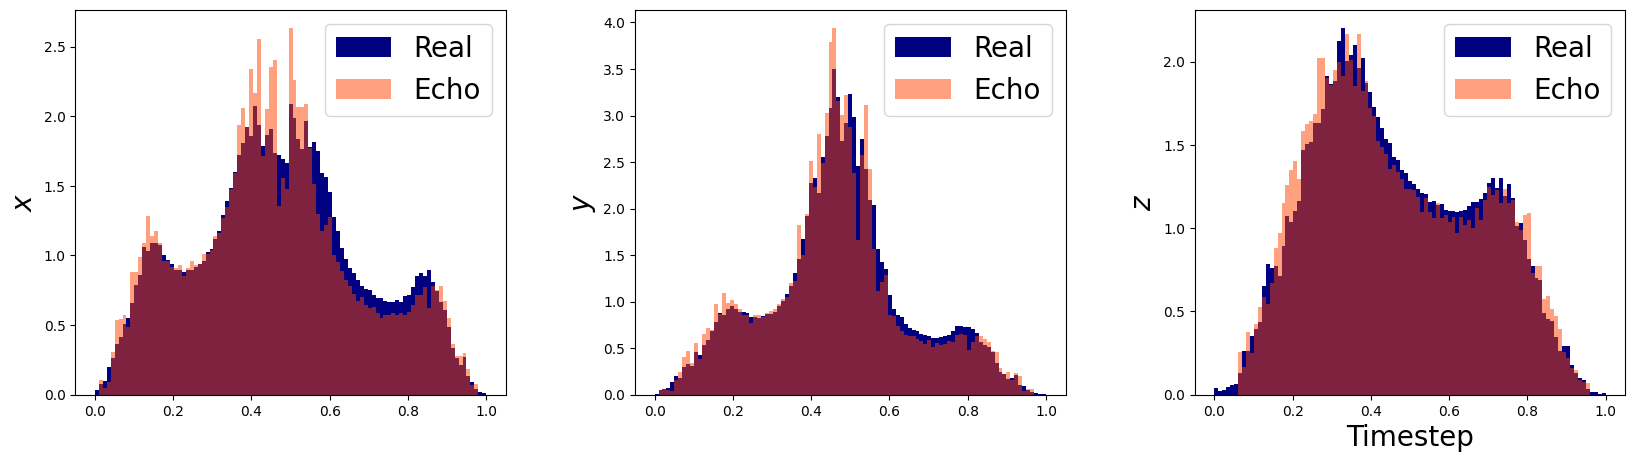

In [14]:
net_sigm = run_nonlinearity(net_sigm, initTraining, idx_start, idx_echo, nLoops)

In [7]:
initTraining = 100

In [8]:
idx_start = 5000
idx_echo = 1000
nLoops = 10000

net.fit_alpha(xyz, initTraining, idx_start, idx_echo, nLoops,
              alpha_min = 1e-8, alpha_max = 1e-1, NAlpha = 30)

New MSE: 14.50624 for alpha = 1e-08
New MSE: 13.62753 for alpha = 0.08965517344827587


In [9]:
net.alpha, net.MSE_echo

(0.08965517344827587, 13.627525840803402)

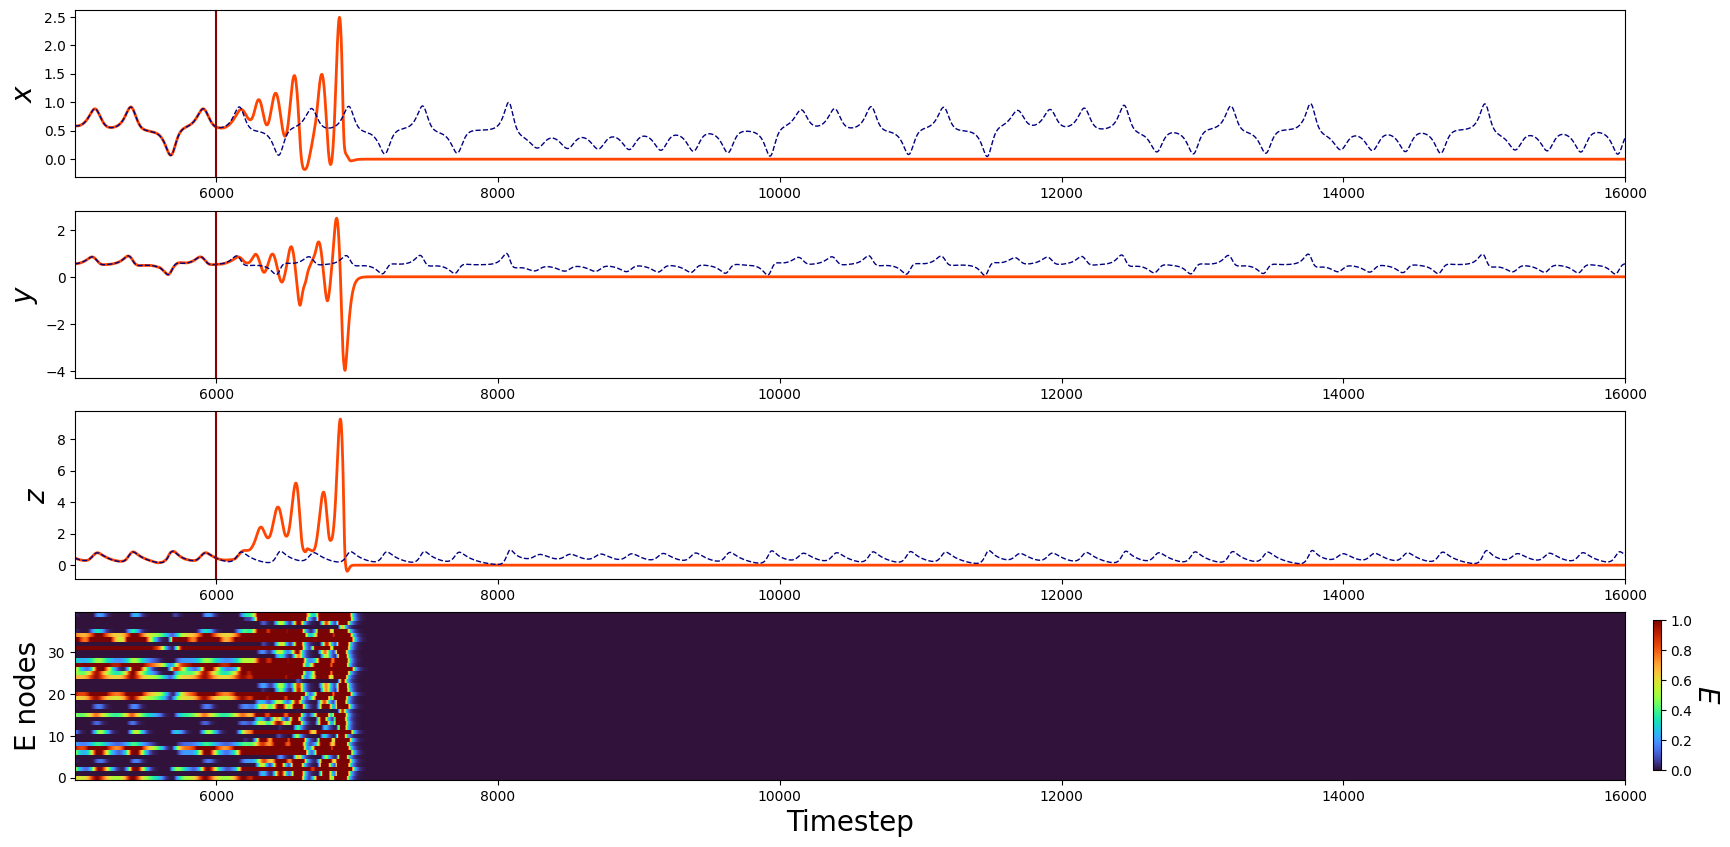

In [10]:
E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start,
                                             idx_echo = idx_echo, plot = True)

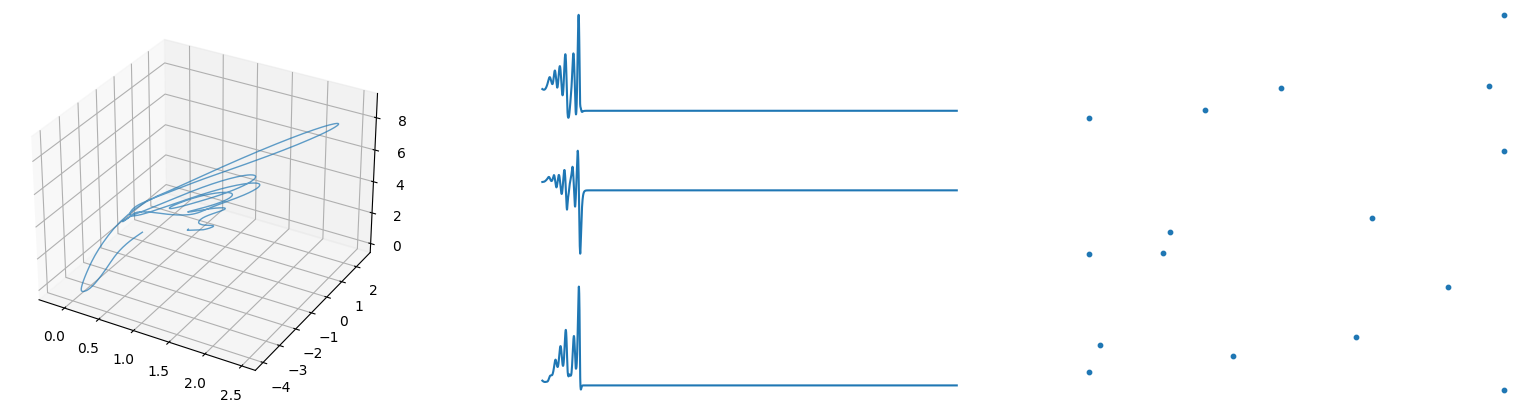

In [11]:
net.plot_attractor(output_echo[idx_echo:])

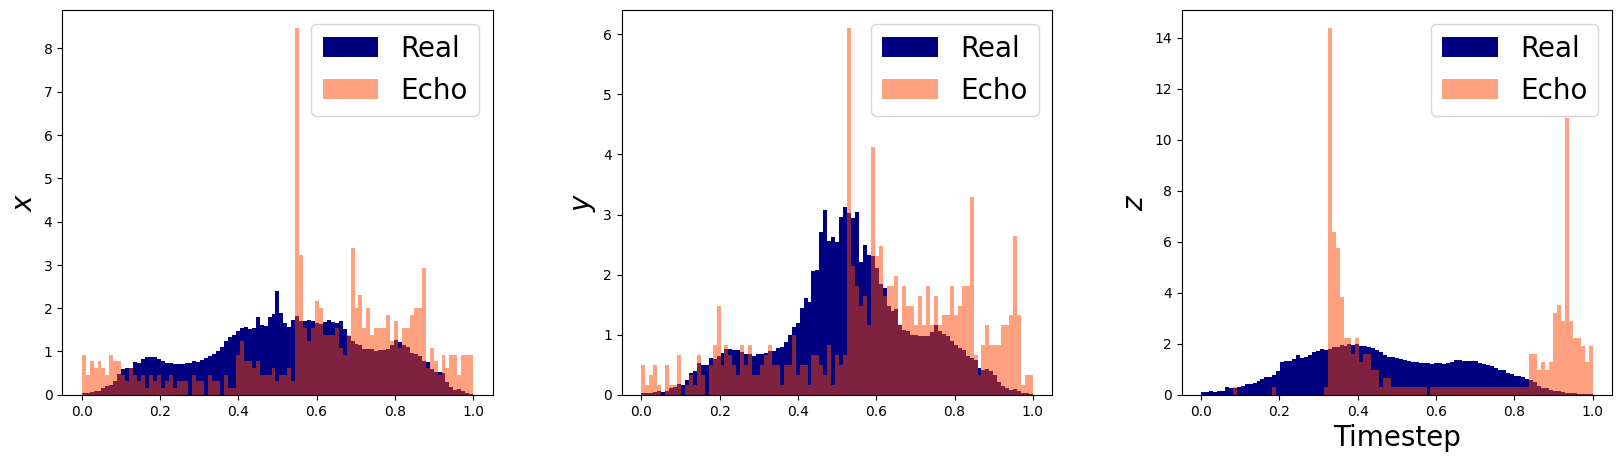

In [12]:
_ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)